######  <span style="font-family: Arial; font-weight:bold;font-size:1.5em;color:#35c337">NLP: Text Classification2 

######  <span style="font-family: Arial; font-weight:bold;font-size:1.0em;color:#a9c335">Importing relevant libraries

In [29]:
import pandas as pd 
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import re
import nltk
import tensorflow as tf
from nltk.corpus import stopwords
nltk.download('stopwords')
from tensorflow import keras
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Dropout
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Embedding, Flatten, GlobalMaxPool1D, Conv1D
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam
from sklearn.feature_extraction.text import TfidfVectorizer
from wordcloud import WordCloud
from sklearn.model_selection import RandomizedSearchCV
from nltk.stem import WordNetLemmatizer 
nltk.download('wordnet')

import warnings
warnings.filterwarnings("ignore")

[nltk_data] Downloading package stopwords to
[nltk_data]     /home/jayanthikishore/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /home/jayanthikishore/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


######  <span style="font-family: Arial; font-weight:bold;font-size:1.0em;color:#83c335">Load Train and Test data

In [2]:
# train = pd.read_csv('/Users/preethamvignesh/Desktop/Work/ML_EIT/Data/corona_nlpdata/Corona_NLP_train.csv',encoding='latin')
# test = pd.read_csv('/Users/preethamvignesh/Desktop/Work/ML_EIT/Data/corona_nlpdata/Corona_NLP_test.csv', encoding ='latin')

train = pd.read_csv('/home/jayanthikishore/Desktop/Analysis/Work/ML_EIT/Data/corona_nlpdata/Corona_NLP_train.csv',encoding='latin')
test = pd.read_csv('/home/jayanthikishore/Desktop/Analysis/Work/ML_EIT/Data/corona_nlpdata/Corona_NLP_test.csv', encoding ='latin')

######  <span style="font-family: Arial; font-weight:bold;font-size:1.0em;color:#59c335">Data Exploration

In [3]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41157 entries, 0 to 41156
Data columns (total 6 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   UserName       41157 non-null  int64 
 1   ScreenName     41157 non-null  int64 
 2   Location       32567 non-null  object
 3   TweetAt        41157 non-null  object
 4   OriginalTweet  41157 non-null  object
 5   Sentiment      41157 non-null  object
dtypes: int64(2), object(4)
memory usage: 1.9+ MB


In [4]:
train

,UserName,ScreenName,Location,TweetAt,OriginalTweet,Sentiment
0,3799,48751,London,16-03-2020,@MeNyrbie @Phil_Gahan @Chrisitv https://t.co/i...,Neutral
1,3800,48752,UK,16-03-2020,advice Talk to your neighbours family to excha...,Positive
2,3801,48753,Vagabonds,16-03-2020,Coronavirus Australia: Woolworths to give elde...,Positive
3,3802,48754,NaN,16-03-2020,My food stock is not the only one which is emp...,Positive
4,3803,48755,NaN,16-03-2020,"Me, ready to go at supermarket during the #COV...",Extremely Negative
...,...,...,...,...,...,...
41152,44951,89903,"Wellington City, New Zealand",14-04-2020,Airline pilots offering to stock supermarket s...,Neutral
41153,44952,89904,NaN,14-04-2020,Response to complaint not provided citing COVI...,Extremely Negative
41154,44953,89905,NaN,14-04-2020,You know itÂs getting tough when @KameronWild...,Positive
41155,44954,89906,NaN,14-04-2020,Is it wrong that the smell of hand sanitizer i...,Neutral


######  <span style="font-family: Arial; font-weight:bold;font-size:1.0em;color:#35c354">Shape of the Dataset

In [5]:
train.shape

(41157, 6)

######  <span style="font-family: Arial; font-weight:bold;font-size:1.0em;color:#35c383">Replace sentiments in column

In [6]:
#Replace Extremely Positive & Negative with Positive and Negative
train.loc[train.Sentiment == 'Extremely Negative','Sentiment'] = 'Negative'
train.loc[train.Sentiment == 'Extremely Positive', 'Sentiment'] = 'Positive'

test.loc[test.Sentiment == 'Extremely Negative', 'Sentiment'] = 'Negative'
test.loc[test.Sentiment == 'Extremely Positive', 'Sentiment'] = 'Positive'

train

,UserName,ScreenName,Location,TweetAt,OriginalTweet,Sentiment
0,3799,48751,London,16-03-2020,@MeNyrbie @Phil_Gahan @Chrisitv https://t.co/i...,Neutral
1,3800,48752,UK,16-03-2020,advice Talk to your neighbours family to excha...,Positive
2,3801,48753,Vagabonds,16-03-2020,Coronavirus Australia: Woolworths to give elde...,Positive
3,3802,48754,NaN,16-03-2020,My food stock is not the only one which is emp...,Positive
4,3803,48755,NaN,16-03-2020,"Me, ready to go at supermarket during the #COV...",Negative
...,...,...,...,...,...,...
41152,44951,89903,"Wellington City, New Zealand",14-04-2020,Airline pilots offering to stock supermarket s...,Neutral
41153,44952,89904,NaN,14-04-2020,Response to complaint not provided citing COVI...,Negative
41154,44953,89905,NaN,14-04-2020,You know itÂs getting tough when @KameronWild...,Positive
41155,44954,89906,NaN,14-04-2020,Is it wrong that the smell of hand sanitizer i...,Neutral


######  <span style="font-family: Arial; font-weight:bold;font-size:1.0em;color:#35c3b7">Counting Sentiments

In [7]:
from collections import Counter
test_cnt = Counter(test.Sentiment)
train_cnt = Counter(train['Sentiment'])
print(test_cnt)
print(train_cnt)

Counter({'Negative': 1633, 'Positive': 1546, 'Neutral': 619})
Counter({'Positive': 18046, 'Negative': 15398, 'Neutral': 7713})


Text(0.5, 1.0, 'Test dataset')

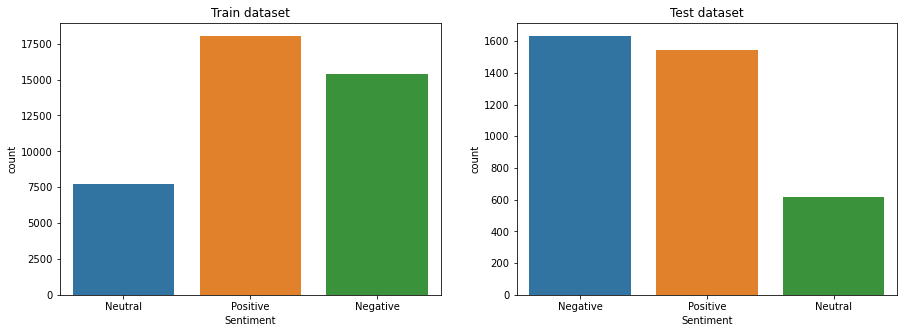

In [8]:
f, axes = plt.subplots(ncols=2, figsize=(15, 5))

sns.countplot(train.Sentiment,ax=axes[0])
axes[0].set_title('Train dataset')

sns.countplot(test.Sentiment,ax=axes[1])
axes[1].set_title('Test dataset')

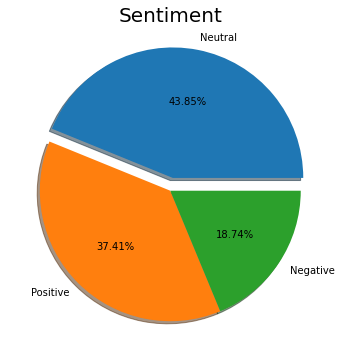

In [9]:
labls = ['Neutral', 'Positive','Negative']
size = train['Sentiment'].value_counts()
explode = [0.1,0,0]

plt.rcParams['figure.figsize'] = (6, 6)
plt.pie(size, explode = explode, labels = labls, shadow = True, autopct = '%.2f%%')
plt.title('Sentiment', fontsize = 20)
plt.axis('off')
# plt.legend()
plt.show()

######  <span style="font-family: Arial; font-weight:bold;font-size:1.0em;color:#35b0c3">Count Locationwise

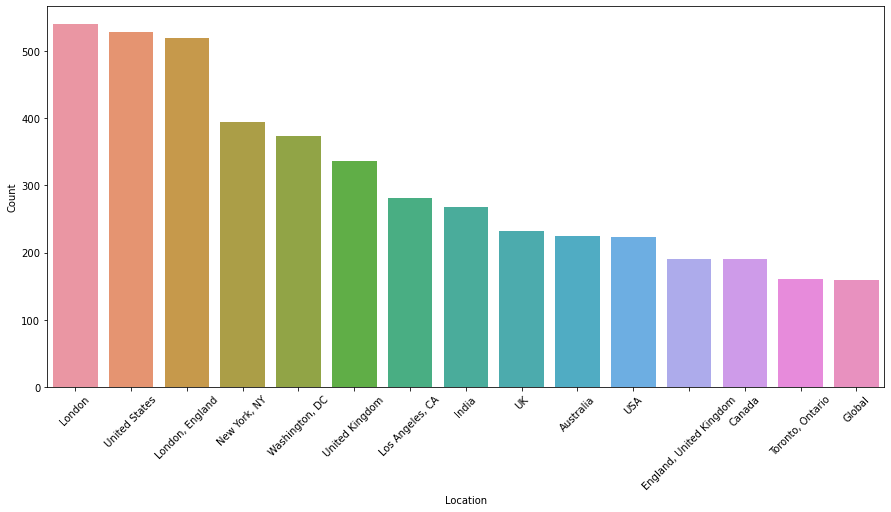

In [10]:
import matplotlib.pyplot as plt
import pandas as pd
location = train.Location
location = pd.DataFrame(location)
location['Count'] = 1
location = location.groupby('Location').sum().sort_values(by = 'Count', ascending = False).nlargest(15,['Count'])
location = location.reset_index()


plt.figure(figsize=(15,7))
# norm = plt.Normalize(location.min(), location.max())
# cmap = plt.get_cmap("magma")
sns.barplot(x = 'Location',y = 'Count', data=location)
plt.xticks(rotation=45)

plt.show()

In [11]:
time = train.TweetAt
time = pd.DataFrame(time)
Min = time.TweetAt.min()
Max = time.TweetAt.max()
print(f'The date range of the data is between {Min} and {Max}')

The date range of the data is between 01-04-2020 and 31-03-2020


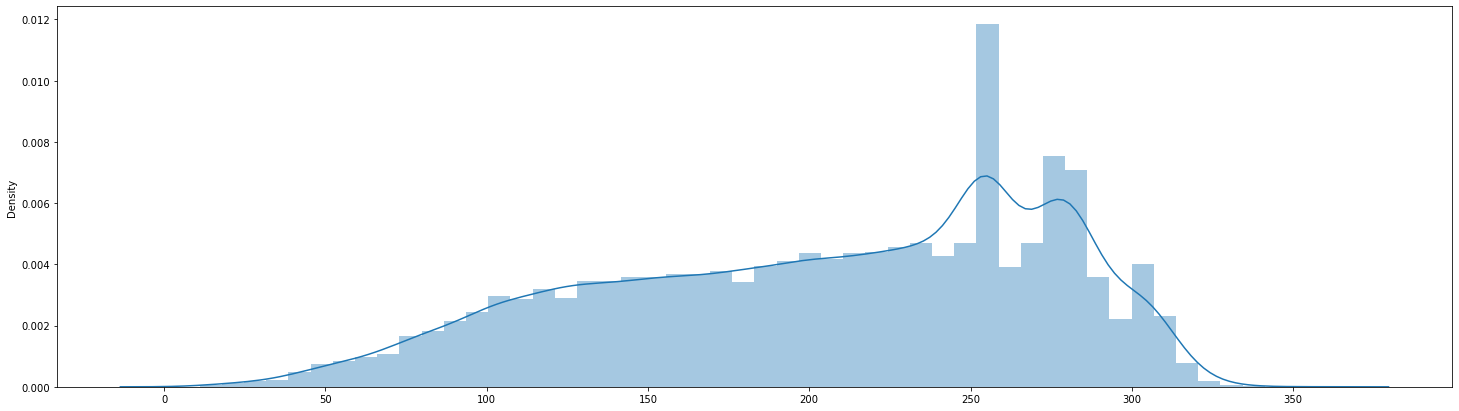

In [12]:
length_tweets = pd.DataFrame(train.OriginalTweet)
length_measured = []
for i in length_tweets.OriginalTweet:
 length_measured.append(len(i))

plt.figure(figsize=(25,7))
sns.distplot(length_measured)

######  <span style="font-family: Arial; font-weight:bold;font-size:1.0em;color:#35b0c3">Data Cleaning and drop some variables

In [13]:
train = train.drop(['UserName','ScreenName'], axis = 1)
test = test.drop(['UserName','ScreenName'], axis = 1)

In [14]:
#Transform it into a datetime column
train['TweetAt'] = pd.to_datetime(train['TweetAt'], format = '%d-%m-%Y')
test['TweetAt'] = pd.to_datetime(test['TweetAt'], format = '%d-%m-%Y')

train.rename(columns={'OriginalTweet': 'Tweet'}, inplace=True)
test.rename(columns={'OriginalTweet': 'Tweet'}, inplace=True)

#Remove urls:
train.Tweet = train.Tweet.str.replace('http\S+|www.\S+', '', case=False)
test.Tweet = test.Tweet.str.replace('http\S+|www.\S+', '', case=False)

# Remove punctuation, special characters & mentions:
train.Tweet = train.Tweet.str.replace(r'[^\w\s]', '', case=False)
test.Tweet = test.Tweet.str.replace(r'[^\w\s]', '', case=False)

# #Remove stopwords:
stop_words = set(stopwords.words('english'))
train.Tweet = train.Tweet.apply(lambda x: ' '.join([word for word in x.split() if word not in (stop_words)]))
test.Tweet = test.Tweet.apply(lambda x: ' '.join([word for word in x.split() if word not in (stop_words)]))

#Remove non alphabetic words:
train.Tweet = train.Tweet.apply(lambda x: ' '.join([word for word in x.split() if word.isalpha()]))
test.Tweet = test.Tweet.apply(lambda x: ' '.join([word for word in x.split() if word.isalpha()]))

#Remove emptys rows:
train = train[train.Tweet != '']
test = test[test.Tweet != '']

#Initiate a lemmatizer and lemmatize each word in the data
lemmatizer = WordNetLemmatizer()
train.Tweet = train.Tweet.apply(lambda x: ' '.join([lemmatizer.lemmatize(word) for word in x.split()]))
test.Tweet = test.Tweet.apply(lambda x: ' '.join([lemmatizer.lemmatize(word) for word in x.split()]))

######  <span style="font-family: Arial; font-weight:bold;font-size:1.0em;color:#354dc3">check the tweets are cleaned are not

In [15]:
for i in range(0,5):
    print(i,':',train.Tweet[i])
    print(i,':',test.Tweet[i])

0 : MeNyrbie Chrisitv
0 : TRENDING New Yorkers encounter empty supermarket shelf pictured Wegmans Brooklyn soldout online grocer FoodKick MaxDelivery coronavirusfearing shopper stock
1 : advice Talk neighbour family exchange phone number create contact list phone number neighbour school employer chemist GP set online shopping account po adequate supply regular med order
1 : When I couldnt find hand sanitizer Fred Meyer I turned Amazon But pack PurellCheck coronavirus concern driving price
2 : Coronavirus Australia Woolworths give elderly disabled dedicated shopping hour amid outbreak
2 : Find protect loved one coronavirus
3 : My food stock one empty PLEASE dont panic THERE WILL BE ENOUGH FOOD FOR EVERYONE take need Stay calm stay safe coronavirus confinement Confinementotal ConfinementGeneral
3 : Panic buying hit NewYork City anxious shopper stock foodampmedical supply healthcare worker becomes BigApple confirmed coronavirus patient OR Bloomberg staged event QAnon CDC
4 : Me ready go s

######  <span style="font-family: Arial; font-weight:bold;font-size:1.0em;color:#5635c3">Word Cloud for positive tweets

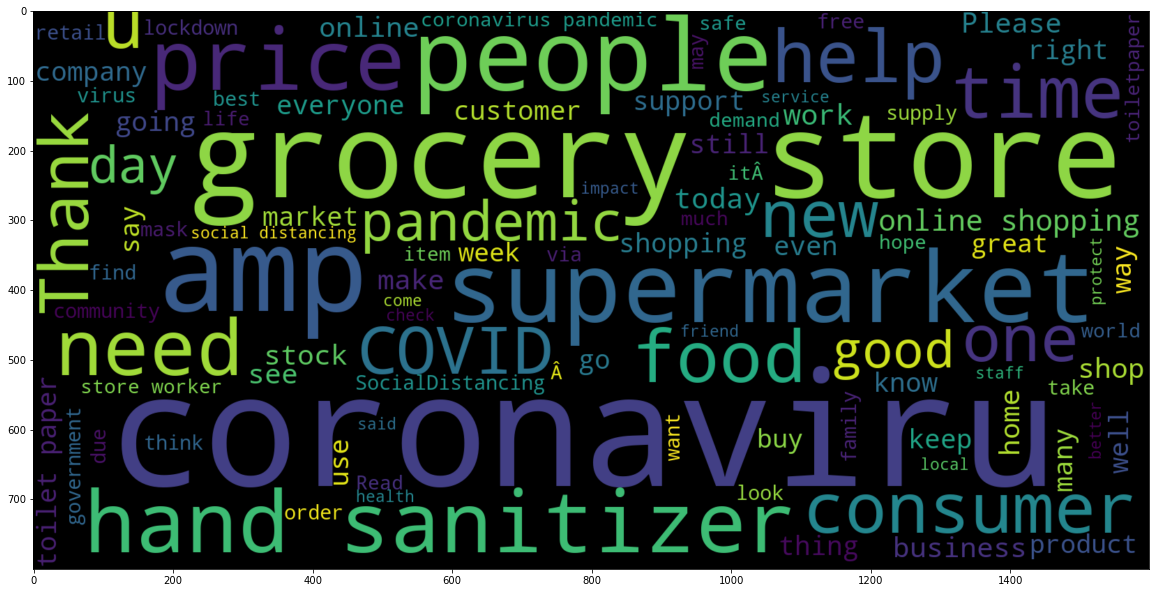

In [16]:
# Top 100 words for positive tweets:
plt.figure(figsize = (20,20)) # Text that is Fake
wc = WordCloud(max_words = 100 , width = 1600 , height = 800).generate(" ".join(train[(train.Sentiment == 'Positive') | (train.Sentiment == 'Extremely Positive')].Tweet))
plt.imshow(wc , interpolation = 'bilinear')

######  <span style="font-family: Arial; font-weight:bold;font-size:1.0em;color:#7e35c3">save the train and test cleaned tweets into local hard disk

In [17]:
# #Save the data cleaned to be an input for our streamlit app
# train.to_csv('/Users/preethamvignesh/Downloads/train_cleaned.csv', index=False)
# test.to_csv('/Users/preethamvignesh/Downloads/test_cleaned.csv', index=False)

In [18]:
#Encode the target:
y_train = pd.get_dummies(train.Sentiment).values
y_test = pd.get_dummies(test.Sentiment).values
y_train

array([[0, 1, 0],
       [0, 0, 1],
       [0, 0, 1],
       ...,
       [0, 0, 1],
       [0, 1, 0],
       [1, 0, 0]], dtype=uint8)

######  <span style="font-family: Arial; font-weight:bold;font-size:1.25em;color:#7e35c3">Embedding Models

In [19]:
train['num_words'] = train.Tweet.apply(lambda x : len(x.split()))
max(train['num_words'])

53

In [20]:
maxlen = 50

tokenizer = Tokenizer(num_words=10000)
tokenizer.fit_on_texts(train.Tweet.values)

X_train = tokenizer.texts_to_sequences(train.Tweet.values)
X_test = tokenizer.texts_to_sequences(test.Tweet.values)

X_train = pad_sequences(X_train, maxlen=maxlen)
X_test = pad_sequences(X_test, maxlen=maxlen)

vocab_size = len(tokenizer.word_index) + 1

######  <span style="font-family: Arial; font-weight:bold;font-size:1.25em;color:#7e35c3">Embedding Model (One Layer)

In [21]:
embedding_dim = 30
opti = Adam(lr = 0.01)

model_onelayer_embed = Sequential()
model_onelayer_embed.add(Embedding(input_dim=vocab_size, 
                           output_dim=embedding_dim, 
                           input_length=maxlen))
model_onelayer_embed.add(Flatten())
model_onelayer_embed.add(Dense(16, activation = 'relu'))
model_onelayer_embed.add(Dense(3, activation = 'softmax'))

In [22]:
model_onelayer_embed.compile(loss = 'categorical_crossentropy', optimizer = opti, metrics = ['accuracy'])
model_onelayer_embed.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 50, 30)            1637460   
_________________________________________________________________
flatten (Flatten)            (None, 1500)              0         
_________________________________________________________________
dense (Dense)                (None, 16)                24016     
_________________________________________________________________
dense_1 (Dense)              (None, 3)                 51        
Total params: 1,661,527
Trainable params: 1,661,527
Non-trainable params: 0
_________________________________________________________________


In [23]:
history_onelayer_embed = model_onelayer_embed.fit(X_train, y_train,
                    epochs=2,
                    verbose=True,
                    validation_data=(X_test, y_test),
                    batch_size=16)

Epoch 1/2
2572/2572 [==============================] - 38s 15ms/step - loss: 0.7971 - accuracy: 0.6413 - val_loss: 0.6367 - val_accuracy: 0.7488
Epoch 2/2
2572/2572 [==============================] - 36s 14ms/step - loss: 0.4228 - accuracy: 0.8466 - val_loss: 0.6794 - val_accuracy: 0.7617


In [ ]:
# #Save models and history
# model_onelayer_embed.save('/Users/preethamvignesh/Downloads/model_onelayer_embed.h5')
# np.save('/Users/preethamvignesh/Downloads/history_onelayer_embed.npy',history_simple_embed.history)

######  <span style="font-family: Arial; font-weight:bold;font-size:1.25em;color:#7e35c3">Embedding Model (Multi Layer)

In [25]:
embedding_dim = 50
opti = Adam(lr = 0.01)

multi_layer_Embed = Sequential()
multi_layer_Embed.add(Embedding(input_dim=vocab_size, 
                           output_dim=embedding_dim, 
                           input_length=maxlen))
multi_layer_Embed.add(Flatten())
multi_layer_Embed.add(Dense(64, activation = 'relu'))
multi_layer_Embed.add(Dense(32, activation = 'relu'))
multi_layer_Embed.add(Dense(16, activation = 'relu'))
multi_layer_Embed.add(Dense(3, activation = 'softmax'))

In [26]:
multi_layer_Embed.compile(loss = 'categorical_crossentropy', optimizer = opti, metrics = ['accuracy'])
multi_layer_Embed.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 50, 50)            2729100   
_________________________________________________________________
flatten_2 (Flatten)          (None, 2500)              0         
_________________________________________________________________
dense_6 (Dense)              (None, 64)                160064    
_________________________________________________________________
dense_7 (Dense)              (None, 32)                2080      
_________________________________________________________________
dense_8 (Dense)              (None, 16)                528       
_________________________________________________________________
dense_9 (Dense)              (None, 3)                 51        
Total params: 2,891,823
Trainable params: 2,891,823
Non-trainable params: 0
____________________________________________

In [27]:
history_multi_Embed = multi_layer_Embed.fit(X_train, y_train,
                    epochs=3,
                    verbose=True,
                    validation_data=(X_test, y_test),
                    batch_size=16)

Epoch 1/3
2572/2572 [==============================] - 71s 28ms/step - loss: 0.8425 - accuracy: 0.6055 - val_loss: 0.6178 - val_accuracy: 0.7680
Epoch 2/3
2572/2572 [==============================] - 65s 25ms/step - loss: 0.4319 - accuracy: 0.8555 - val_loss: 0.5872 - val_accuracy: 0.7875
Epoch 3/3
2572/2572 [==============================] - 61s 24ms/step - loss: 0.2704 - accuracy: 0.9161 - val_loss: 0.7020 - val_accuracy: 0.7649


In [ ]:
# #Save models and history
# multi_layer_Embed.save('/Users/preethamvignesh/Downloads/multi_layer_Embed.h5')
# np.save('/Users/preethamvignesh/Downloads/history_multi_Embed.npy',history_multi_Embed.history)

######  <span style="font-family: Arial; font-weight:bold;font-size:1.25em;color:#7e35c3">Glove Model (one layer)

In [32]:
embeddings_index = {}
with open('/home/jayanthikishore/Desktop/Analysis/Work/ML_EIT/Data/corona_nlpdata/glove.6B.50d.txt') as f:
    for line in f:
        word, coefs = line.split(maxsplit=1)
        coefs = np.fromstring(coefs, "f", sep=" ")
        embeddings_index[word] = coefs

print("Found %s word vectors." % len(embeddings_index))

Found 400000 word vectors.


In [33]:
num_tokens = len(tokenizer.word_index) + 1
embedding_dim = 50
hits = 0
misses = 0

# Prepare embedding matrix
embedding_matrix = np.zeros((num_tokens, embedding_dim))
for word, i in tokenizer.word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        # Words not found in embedding index will be all-zeros.
        # This includes the representation for "padding" and "OOV"
        embedding_matrix[i] = embedding_vector
        hits += 1
    else:
        misses += 1
print("Converted %d words (%d misses)" % (hits, misses))

Converted 27068 words (27513 misses)


In [34]:
embedding_dim = 50
opti = Adam(lr=0.01)

model_onelayer_glove = Sequential()
model_onelayer_glove.add(Embedding(vocab_size, embedding_dim,input_length=maxlen, weights = [embedding_matrix], trainable = False))
model_onelayer_glove.add(Flatten())
model_onelayer_glove.add(Dense(16, activation = 'relu'))
model_onelayer_glove.add(Dense(3, activation = 'softmax'))

In [36]:
model_onelayer_glove.compile(loss = 'categorical_crossentropy', optimizer = opti, metrics = ['accuracy'])
model_onelayer_glove.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, 50, 50)            2729100   
_________________________________________________________________
flatten_3 (Flatten)          (None, 2500)              0         
_________________________________________________________________
dense_10 (Dense)             (None, 16)                40016     
_________________________________________________________________
dense_11 (Dense)             (None, 3)                 51        
Total params: 2,769,167
Trainable params: 40,067
Non-trainable params: 2,729,100
_________________________________________________________________


In [37]:
history_onelayer_glove = model_onelayer_glove.fit(X_train, y_train,
                    epochs=10,
                    verbose=True,
                    validation_data=(X_test, y_test),
                    batch_size=16)

Epoch 1/10
2572/2572 [==============================] - 3s 997us/step - loss: 0.9492 - accuracy: 0.5336 - val_loss: 1.0338 - val_accuracy: 0.5419
Epoch 2/10
2572/2572 [==============================] - 2s 926us/step - loss: 0.8695 - accuracy: 0.6064 - val_loss: 0.8920 - val_accuracy: 0.5793
Epoch 3/10
2572/2572 [==============================] - 2s 938us/step - loss: 0.8590 - accuracy: 0.6089 - val_loss: 0.9168 - val_accuracy: 0.5785
Epoch 4/10
2572/2572 [==============================] - 2s 909us/step - loss: 0.8537 - accuracy: 0.6158 - val_loss: 0.8863 - val_accuracy: 0.5742
Epoch 5/10
2572/2572 [==============================] - 2s 955us/step - loss: 0.8449 - accuracy: 0.6167 - val_loss: 0.9576 - val_accuracy: 0.5155
Epoch 6/10
2572/2572 [==============================] - 2s 912us/step - loss: 0.8429 - accuracy: 0.6196 - val_loss: 0.9159 - val_accuracy: 0.5721
Epoch 7/10
2572/2572 [==============================] - 2s 928us/step - loss: 0.8302 - accuracy: 0.6260 - val_loss: 0.9688 -

In [38]:
# #Save models and history
# model_onelayer_glove.save('/Users/preethamvignesh/Downloads/model_onelayer_glove.h5')
# np.save('/Users/preethamvignesh/Downloads/history_simple_glove.npy',history_onelayer_glove.history)

######  <span style="font-family: Arial; font-weight:bold;font-size:1.25em;color:#7e35c3">Glove Model (Multi layer)

In [39]:
embedding_dim = 50
opti = Adam(lr = 0.01)

model_multi_glove = Sequential()
model_multi_glove.add(Embedding(vocab_size, embedding_dim,input_length=maxlen, weights = [embedding_matrix], trainable = False))
model_multi_glove.add(Flatten())
model_multi_glove.add(Dense(64, activation = 'relu'))
model_multi_glove.add(Dense(32, activation = 'relu'))
model_multi_glove.add(Dense(16, activation = 'relu'))
model_multi_glove.add(Dense(3, activation = 'softmax'))

In [40]:
model_multi_glove.compile(loss = 'categorical_crossentropy', optimizer = 'adam', metrics = ['accuracy'])
model_multi_glove.summary()

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_4 (Embedding)      (None, 50, 50)            2729100   
_________________________________________________________________
flatten_4 (Flatten)          (None, 2500)              0         
_________________________________________________________________
dense_12 (Dense)             (None, 64)                160064    
_________________________________________________________________
dense_13 (Dense)             (None, 32)                2080      
_________________________________________________________________
dense_14 (Dense)             (None, 16)                528       
_________________________________________________________________
dense_15 (Dense)             (None, 3)                 51        
Total params: 2,891,823
Trainable params: 162,723
Non-trainable params: 2,729,100
______________________________________

In [41]:
history_Multi_glove = model_multi_glove.fit(X_train, y_train,
                    epochs=10,
                    verbose=True,
                    validation_data=(X_test, y_test),
                    batch_size=16)

Epoch 1/10
2572/2572 [==============================] - 3s 1ms/step - loss: 0.9117 - accuracy: 0.5603 - val_loss: 0.8668 - val_accuracy: 0.5821
Epoch 2/10
2572/2572 [==============================] - 3s 1ms/step - loss: 0.8085 - accuracy: 0.6394 - val_loss: 0.8660 - val_accuracy: 0.5972
Epoch 3/10
2572/2572 [==============================] - 3s 1ms/step - loss: 0.7534 - accuracy: 0.6621 - val_loss: 0.8968 - val_accuracy: 0.5932
Epoch 4/10
2572/2572 [==============================] - 3s 1ms/step - loss: 0.6792 - accuracy: 0.6994 - val_loss: 0.9116 - val_accuracy: 0.5845
Epoch 5/10
2572/2572 [==============================] - 3s 1ms/step - loss: 0.5897 - accuracy: 0.7478 - val_loss: 1.0060 - val_accuracy: 0.5837
Epoch 6/10
2572/2572 [==============================] - 3s 1ms/step - loss: 0.5077 - accuracy: 0.7901 - val_loss: 1.0951 - val_accuracy: 0.5735
Epoch 7/10
2572/2572 [==============================] - 3s 1ms/step - loss: 0.4328 - accuracy: 0.8249 - val_loss: 1.2890 - val_accuracy:

In [ ]:
# #Save models and history
# model_multi_glove.save('/Users/preethamvignesh/Downloads/model_multi_glove.h5')
# np.save('/Users/preethamvignesh/Downloads/history_Multi_glove.npy',history_Multi_glove.history)